In [ ]:
!pip install pyrsgis
!pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15094 sha256=ae643e710e131cee551db5cf93d3102c66be4e4e90e521f4d5c62528f15901c1
  Stored in directory: /root/.cache/pip/wheels/ef/91/3f/17cbea1e83d17cc01bd2d66a0d59e65301bcb2d59f2f6a62ab
Successfully built func-timeout


In [ ]:
import os, math, numpy as np
from pyrsgis import raster, convert
from osgeo import gdal
from google.colab import drive
from copy import deepcopy
from skimage.metrics import structural_similarity as ssim
from geneticalgorithm import geneticalgorithm as ga
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f2017 = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/2017.tif"
f2020 = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/2020.tif"
road_network_path = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/road.tif"
pop = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/pop.tif"
metro = "/content/drive/MyDrive/Capstone_Data/Bangalore_data/metro.tif"

ds1, arr1 = raster.read(f2017,bands=1)
ds2,arr2 = raster.read(f2020,bands =1)
road_ds,road_arr = raster.read(road_network_path,bands=1)
pop_ds, pop_arr = raster.read(pop,bands=1)
metro_ds,metro_arr = raster.read(metro,bands=1)


if(ds1.RasterXSize == ds2.RasterXSize and ds1.RasterYSize == ds2.RasterYSize and ds1.RasterYSize == road_ds.RasterYSize and  ds1.RasterXSize == road_ds.RasterXSize):
  print("Input File size matched\n")
else:
  print("Input Files are not of same size\n")
  exit()

no_rows = ds1.RasterYSize
no_cols = ds1.RasterXSize

print(no_rows,no_cols)
print(road_ds.RasterYSize,road_ds.RasterXSize)
print(pop_ds.RasterYSize,pop_ds.RasterXSize)
print(metro_ds.RasterYSize,metro_ds.RasterXSize)

Input File size matched

1266 1177
1266 1177
1266 1177
1266 1177


 The best solution found:
 [ 7.71459601e+00  4.92622043e+02 -8.26245078e+00  1.90726822e+02
  1.34350184e-03]

 Objective function:
 -0.5435097047802453


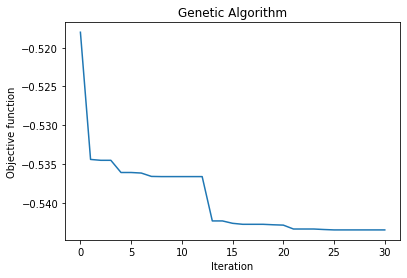

In [ ]:
# Define the fitness function that evaluates the predicted output
def fitness_function(solution):
    builtUpThreshold = solution[0]
    distFromRoad = solution[1]
    popThreshold = solution[2]
    metroThreshold = solution[3]
    errorThreshold = solution[4]

    kernelSize = 3
    predicted_arr = deepcopy(arr1)
    sideMargin = math.ceil(kernelSize/2)

    for y in range(sideMargin,no_rows-(sideMargin-1)):
        for x in range(sideMargin,no_cols-(sideMargin-1)):
            kernel = arr1[y-(sideMargin-1):y+(sideMargin), x-(sideMargin-1):x+(sideMargin)]
            builtupCount = sum(sum(kernel==1))

            if (builtupCount >= builtUpThreshold and road_arr[y,x]<=distFromRoad and arr1[y,x]!=3 and pop_arr[y,x]>=popThreshold and metro_arr[y,x]>=metroThreshold):
                predicted_arr[y,x]=1

            if(random.random()<errorThreshold and arr1[y,x]==2):
              predicted_arr[y,x]=4


    return -ssim(arr2,predicted_arr,data_range=4)

algo_param = {'max_num_iteration': 30,\
                   'population_size': 30,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

# Initialize the genetic algorithm
ga_solver = ga(function=fitness_function, dimension=5, variable_type='real',
               variable_boundaries= np.array([[1,9], [100,500],[-200,100],[100,400],[0,1]]),
               function_timeout= 50,
               algorithm_parameters = algo_param)

ga_solver.run()

In [ ]:
kernelSize = 3
predicted_arr = deepcopy(arr1)
sideMargin = math.ceil(kernelSize/2)
builtUpThreshold = ga_solver.best_variable[0]
distFromRoad = ga_solver.best_variable[1]
popThreshold = ga_solver.best_variable[2]
metroThreshold = ga_solver.best_variable[3]
errorThreshold = ga_solver.best_variable[4]

for y in range(sideMargin,no_rows-(sideMargin-1)):
    for x in range(sideMargin,no_cols-(sideMargin-1)):
        kernel = arr1[y-(sideMargin-1):y+(sideMargin), x-(sideMargin-1):x+(sideMargin)]
        builtupCount = sum(sum(kernel==1))

        if (builtupCount >= builtUpThreshold and road_arr[y,x]<=distFromRoad and arr1[y,x]!=3 and pop_arr[y,x]>=popThreshold and metro_arr[y,x]>=metroThreshold):
            predicted_arr[y,x]=1

        if(arr1[y,x]==2 or arr1[y,x]==4):
                if(random.random()<errorThreshold):
                    if(arr1[y,x]==2):
                        predicted_arr[y,x]=4
                    else:
                        predicted_arr[y,x]=2

def exportPredicted(outFileName):
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(outFileName, no_cols, no_rows, 1, gdal.GDT_UInt16) # option: GDT_UInt16, GDT_Float32
    outdata.SetGeoTransform(ds1.GetGeoTransform())
    outdata.SetProjection(ds1.GetProjection())
    outdata.GetRasterBand(1).WriteArray(predicted_arr)
    outdata.GetRasterBand(1).SetNoDataValue(0)
    outdata.FlushCache()
    outdata = None

print("SSI-Metric:", ssim(arr2,predicted_arr,data_range=4))
#exportPredicted("GA_errorThreshold_2020.tif")
